In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (12.6 MB/s)
debconf: unable to initia

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pytesseract, cv2, os
from glob import glob
from tqdm import tqdm
from statistics import mean, median, stdev
from sklearn.cluster import AgglomerativeClustering

# Google collabr cv2.imshow() alternative implementation
from google.colab.patches import cv2_imshow

# Seaborn style settings
sns.set_theme(style = "ticks",
              palette = sns.dark_palette("seagreen", reverse=True))

# OpenCV and PyTesseract verions
print(f"OpenCV version: {cv2.__version__}")
print(f"PyTesseract version: {pytesseract.__version__}")

OpenCV version: 4.6.0
PyTesseract version: 0.3.10


In [ ]:
# Input and output directories
os.mkdir('data/')
os.mkdir('output/')
os.mkdir('output/png/')
os.mkdir('output/csv/')

In [ ]:
# Reading images' paths from data directory
images = glob('data/*.png')
images

['data/Rent_Report_-_June_2019.width-720.png',
 'data/Rent_Report_-December_2020_1.width-720.png',
 'data/Rent_Report_-_August_2021.width-720.png',
 'data/Rent_Report_-_August_2020.width-720.png',
 'data/Rent_Report_-_March_2022.width-720.png',
 'data/Rent_Report_-_May_2022_.width-720.png',
 'data/Rent_Report_-_May_2021_1.width-720.png',
 'data/Rent_Report_-_February_2021.width-720.png',
 'data/rent_report_-_November_2021.width-720.png',
 'data/Rent_Report_-_April_2019.width-720-431x1024.png',
 'data/Rent_Report_Graphic__-_August_2022_2.width-720.png',
 'data/Rent_Report_-_May_2019.width-720-431x1024.png',
 'data/Rent_Report_-_March_2021.width-720.png',
 'data/Rent_Report_-_April_2021_1.width-720.png',
 'data/Rent_Report_-_October_2019.width-720.png',
 'data/Rent_Report_-_February_2020.width-720.png',
 'data/Rent_Report_-_October_2021.width-720.png',
 'data/Rent-Report-November-2020-1-1-e1611353009250.png',
 'data/Rent_Report_Graphic__-_July_2022.width-720.png',
 'data/Rent_Report_-_Ma

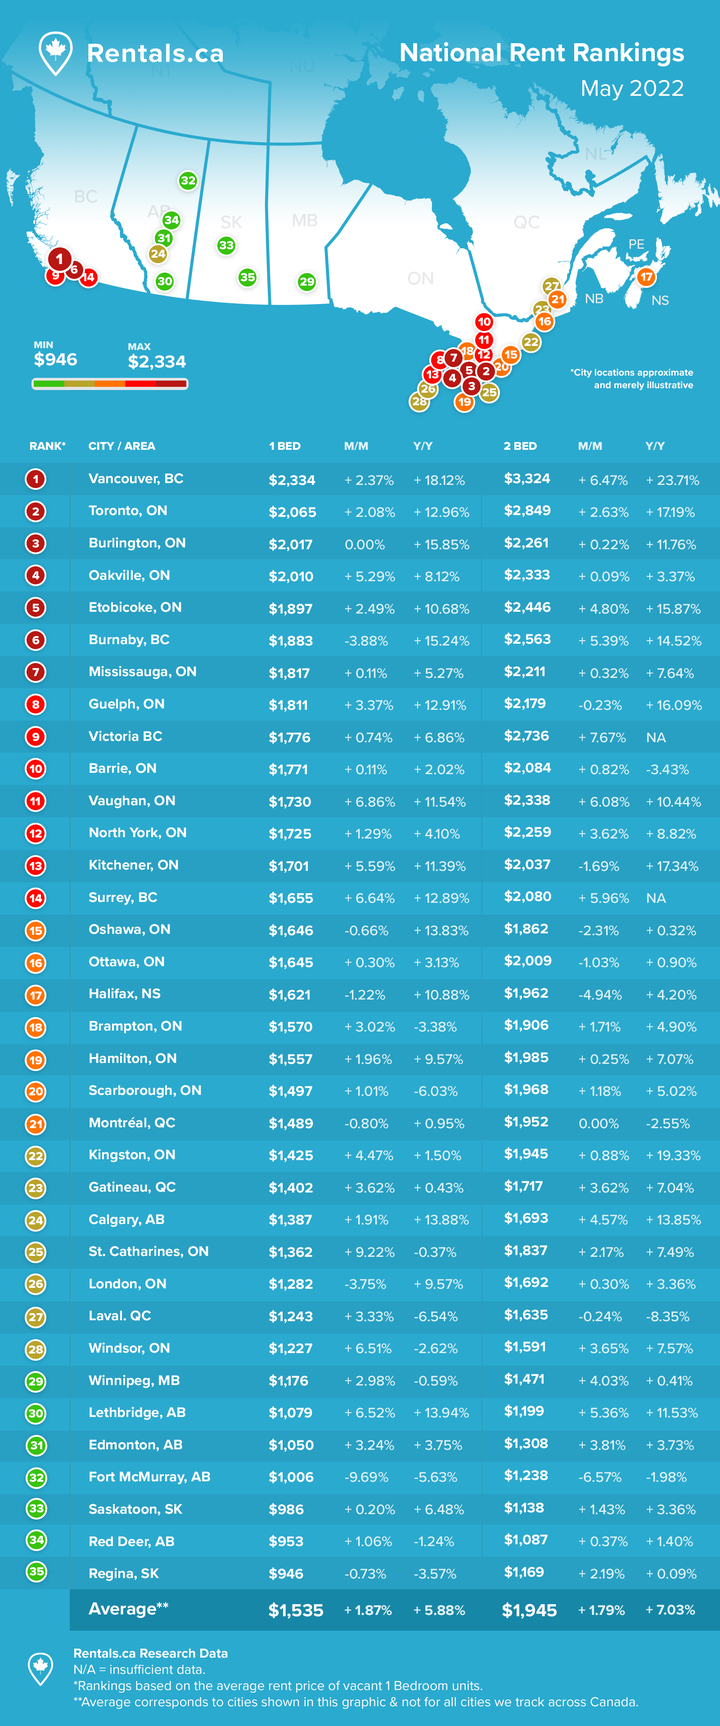

In [ ]:
# Displaying sample image
cv2_imshow(cv2.imread(images[5]))

In [ ]:
def preprocess(image,
               resize = False,
               preserve_ar = True,
               grayscale = False,
               gaussian_blur = False,
               thresholding = False,
               thresh_value = 127,
               verbose = True):
  '''
  Preprocess image object input with:
  image: image input file path;
  resize: Resize to desired width and height dimensions. Takes arguments tuple
    (width, height), single Integer as target width or false boolean. Will
    inforce aspect ratio based on passed target width if preserve_ar argument is
    set to True. Default = False. Default = True if resize argument is integer;
  preserve_ar: Boolean argument to preserve original image's Aspect Ratio or
    redefine based on 'resize' input. Default = True;
  grayscale: OpenCV grayscaling. Takes argument boolean = True or False.
    Default = False;
  gaussian_blur: Smooth image input with a gaussian blurring method. Takes
    arguments Integer kernel size or false boolean. Default = False;
  thresholding: OpenCV simple thresholding. Takes arguments [binary, binary_inv]
    or false boolean. Default = False;
  thresh_value: OpenCV threshold value. Takes argument Int. Default = 127;
  '''
  # Image load and input dimensions
  input_file = image
  image = cv2.imread(image)
  input_height = int(image.shape[0])
  input_width = int(image.shape[1])
  aspect_ratio = input_height/input_width
  
  if verbose:
    print(f"Processing input file: {input_file}...")

  # Resizing
  if type(resize) == int:
    resize = (resize,)

  if resize:
    if preserve_ar:
      image = cv2.resize(image, (resize[0], int(resize[0]*aspect_ratio)))
    else:
      image = cv2.resize(image, (resize[0], input_height))
  
  output_height = int(image.shape[0])
  output_width = int(image.shape[1])

  # Gray-scaling
  if grayscale:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Blurring
  if gaussian_blur:
    image = cv2.GaussianBlur(image, (5, 5), gaussian_blur)

  # Thresholding
  if thresholding:
    if thresholding == "binary":
      image = cv2.threshold(image, thresh_value, 255, cv2.THRESH_BINARY_INV)[1]
    elif thresholding == "binary_inv":
      image = cv2.threshold(image, thresh_value, 255, cv2.THRESH_BINARY_INV)[1]
    else:
      print("Invalid thresholding argument!")
  
  if verbose:
    print(f"Image input dimensions: {(input_width, input_height)}\n"\
          f"Image output dimensions: {(output_width, output_height)}\n")
  return image

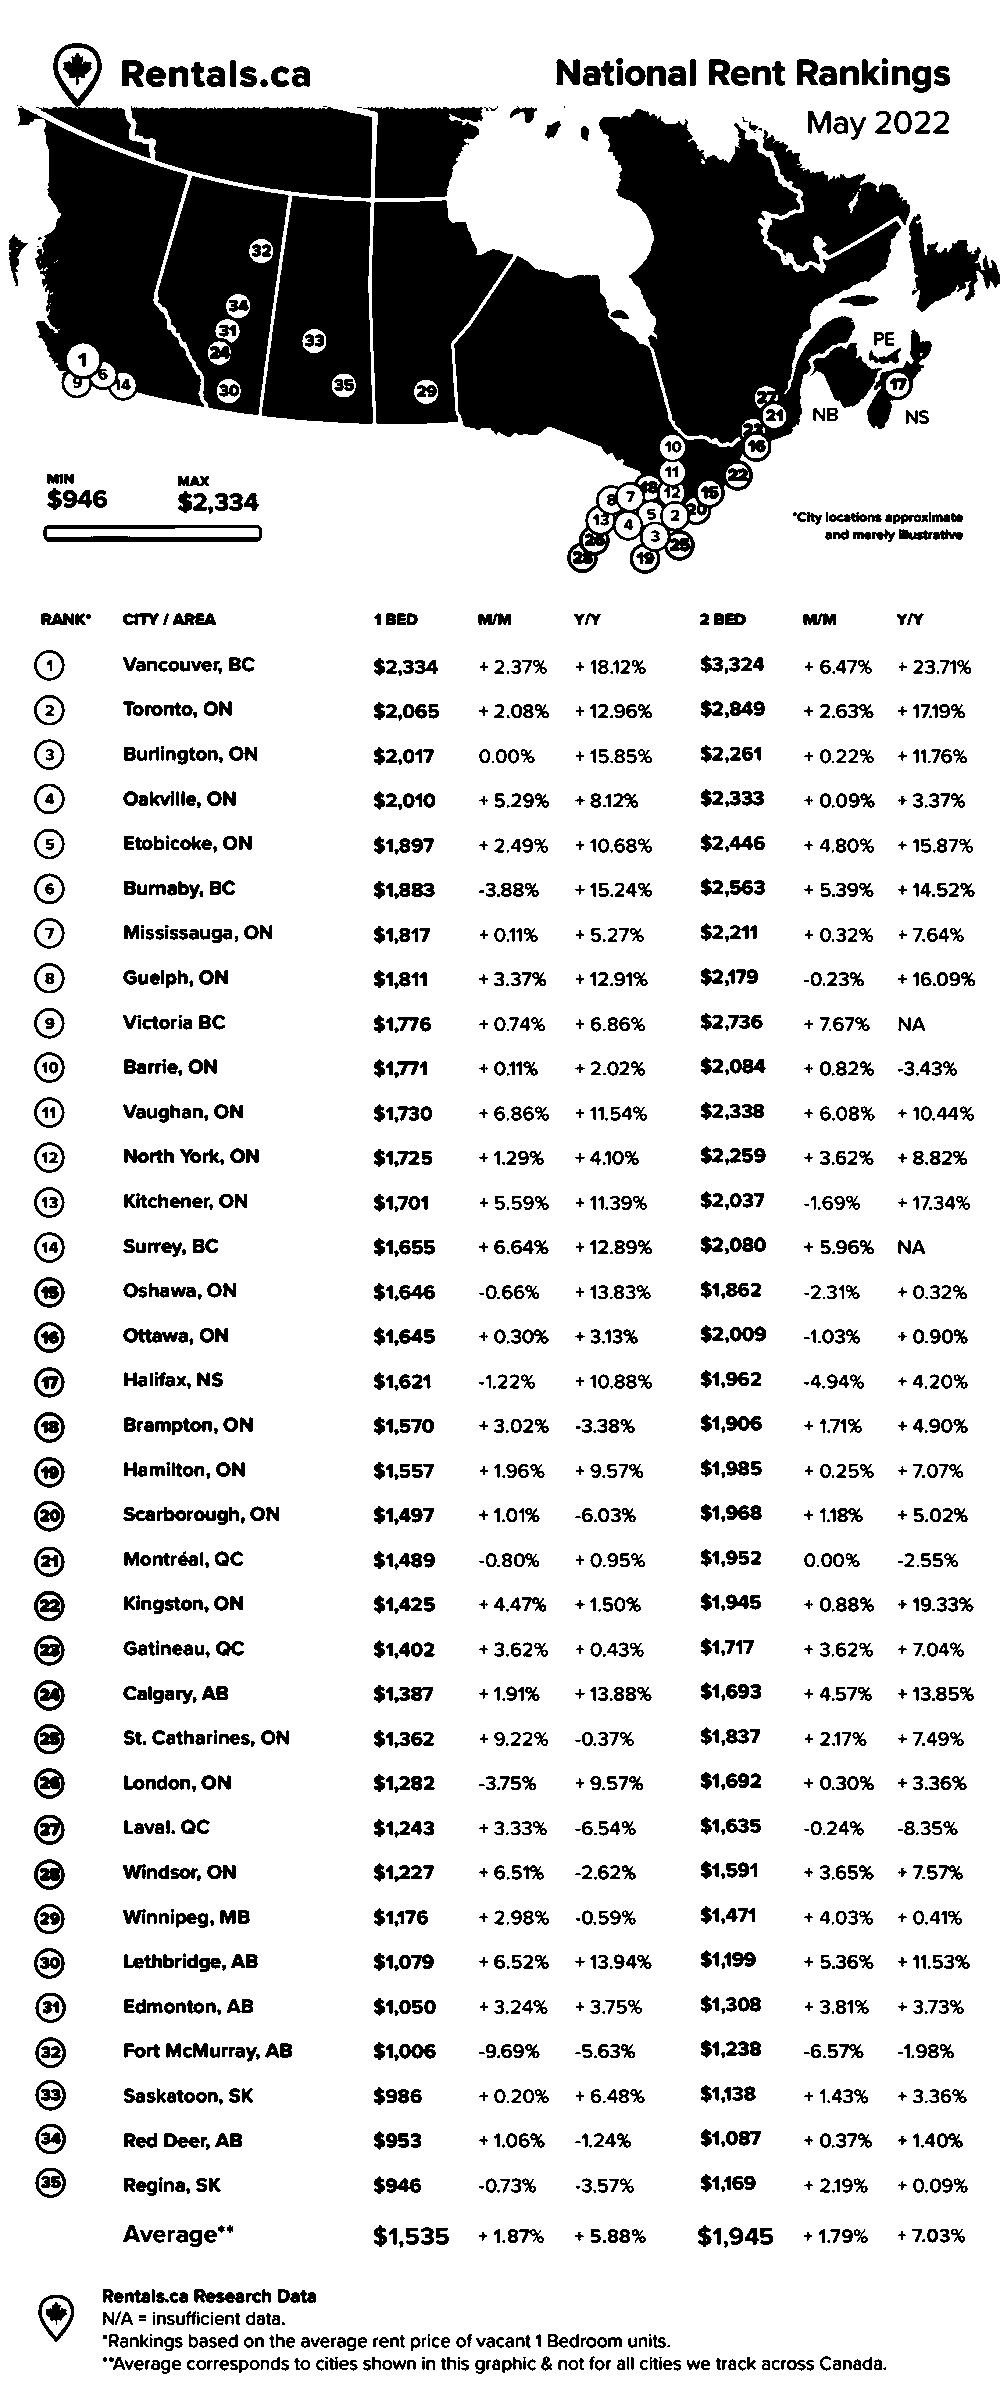

In [ ]:
# Preprocessing parameters
preprocess_args = {
        "resize": 1000,
        "preserve_ar": True,
        "grayscale": True,
        "thresholding": "binary",
        "thresh_value": 165,
        "verbose": False
}

preprocessed_image = preprocess(images[5], **preprocess_args)
cv2_imshow(preprocessed_image)

In [ ]:
!tesseract --help-psm

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.


In [ ]:
def draw_table(image,
               pytesseract_config = "--psm 4",
               conf_thresh = 0):
  '''
  Parsing image input with PyTesseract and extracting coordinates, bounding
  boxes, parsed text, and confidence levels.
  pytesseract_config: Pytesseract OCR config argument. String.
  Default = "--psm 4";
  conf_thresh: Minimum confidence value for thresholding OCR results. Positive
  integer. Default = 0;
  '''

  # Pytesseract image_to_data method on input image
  OCRdict = pytesseract.image_to_data(image,
                                      lang = 'eng',
                                      output_type = pytesseract.Output.DICT,
                                      config = pytesseract_config)
  
  # Initializing coords, gaps, and OCR text list
  coords = []
  h_gaps = []
  v_gaps = []
  OCRtext = []
  confs = []

  for i in range(0, len(OCRdict["text"])):
    # Retrieving current text and bounding box coordinates
    x0 = OCRdict["left"][i]
    y0 = OCRdict["top"][i]
    w0 = OCRdict["width"][i]
    h0 = OCRdict["height"][i]
    text0 = OCRdict["text"][i]
    conf0 = OCRdict["conf"][i]

    # Retrieving following text and bounding box coordinates
    try:
      x1 = OCRdict["left"][i+1]
      y1 = OCRdict["top"][i+1]
      w1 = OCRdict["width"][i+1]
      h1 = OCRdict["height"][i+1]
    except:
      pass
    
    # Calculating vertical and horizontal gaps to next element
    h_gap = x1 - (x0 + w0)
    v_gap = y1 - (y0 + h0)

    # Filtering out characters with confidence level below predefined threshold
    # Filtering out undefined bounding boxes where OCR height and width are
    # higher than half input image height and width
    if (conf0 > conf_thresh) and (h0 < image.shape[0]/2) and (w0 < image.shape[1]/2):
      coords.append((x0, y0, w0, h0))
      h_gaps.append(h_gap)
      v_gaps.append(v_gap)
      OCRtext.append(text0)
      confs.append(conf0)

  table = {}
  table['coords'] = coords
  table['h_gaps'] = h_gaps
  table['v_gaps'] = v_gaps
  table['OCRtext'] = OCRtext
  table['confs'] = confs

  return table

In [ ]:
extracted_table = draw_table(preprocessed_image)

OCRdf = {
    'Coordinates': extracted_table['coords'],
    'h_gaps': extracted_table['h_gaps'],
    'v_gaps': extracted_table['v_gaps'],
    'Text': extracted_table['OCRtext'],
    'Conf:': extracted_table['confs']
}

pd.DataFrame(OCRdf)[25:45]

,Coordinates,h_gaps,v_gaps,Text,Conf:
25,"(897, 613, 27, 12)",-890,25,vie,82
26,"(123, 657, 99, 17)",7,-17,"Vancouver,",95
27,"(229, 657, 26, 15)",119,-14,BC,95
28,"(374, 658, 64, 18)",42,-16,"$2,334",47
29,"(480, 660, 67, 14)",29,-14,+2.37%,46
30,"(576, 660, 70, 14)",55,-19,+1812%,41
31,"(701, 655, 63, 19)",41,-14,"$3,324",26
32,"(805, 660, 67, 14)",27,-14,+647%,2
33,"(899, 660, 72, 14)",-937,21,+23.71%,67
34,"(34, 695, 31, 30)",58,-24,@,78


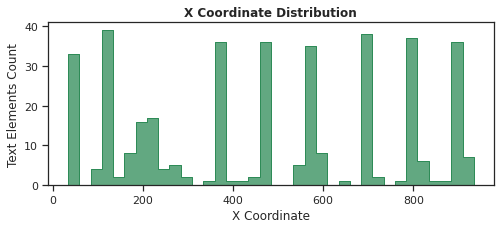

In [ ]:
# Visualizing X Coordinates distribution
plt.figure(figsize = (8, 3))
hist = sns.histplot(x = [x[0] for x in extracted_table['coords']],
                    element = "step",
                    binwidth = 25)
hist.set_title("X Coordinate Distribution", size = 12, weight = "bold")
hist.set(xlabel = "X Coordinate", ylabel = "Text Elements Count")
plt.show()

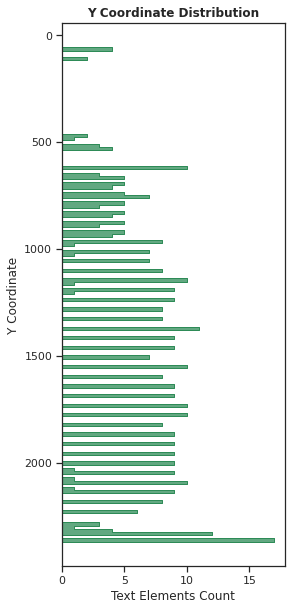

In [ ]:
# Visualizing Y Coordinates distribution
plt.figure(figsize = (4, 10))
hist = sns.histplot(y = [y[1] for y in extracted_table['coords']],
                    element = "step",
                    binwidth = 15)
hist.invert_yaxis()
hist.set_title("Y Coordinate Distribution", size = 12, weight = "bold")
hist.set(xlabel = "Text Elements Count", ylabel = "Y Coordinate")
plt.show()

In [ ]:
# Clustering X coordinates
x_coords = [(x[0], 0) for x in extracted_table['coords']]

clustering = AgglomerativeClustering(n_clusters = None,
                                     affinity = "manhattan",
                                     linkage = "complete",
                                     distance_threshold = 3)

clustering.fit(x_coords)

AgglomerativeClustering(affinity='manhattan', distance_threshold=3,
                        linkage='complete', n_clusters=None)

In [ ]:
# Initializing vertical lines list and defining horizontal padding
v_lines = []
h_padding = 10

# Iterating through X coordinates clusters
for cluster in np.unique(clustering.labels_):
  ids = np.where(clustering.labels_ == cluster)[0]
  
  # Filtering out outlier clusters with less than 10 observations
  if len(ids) > 10:
    # Averaging X coordinates within clusters
    avg_x = np.average([extracted_table['coords'][i][0] for i in ids])
    v_lines.append(int(avg_x) - h_padding)

v_lines.sort()
n_columns = len(v_lines)

In [ ]:
# Clustering Y coordinates
y_coords = [(0, y[1]) for y in extracted_table['coords']]

clustering = AgglomerativeClustering(n_clusters = None,
                                     affinity = "manhattan",
                                     linkage = "complete",
                                     distance_threshold = 25)

clustering.fit(y_coords)

AgglomerativeClustering(affinity='manhattan', distance_threshold=25,
                        linkage='complete', n_clusters=None)

In [ ]:
# Initializing horizontal lines list and defining horizontal padding
h_lines = []
v_padding = 10

# Iterating through Y coordinates clusters
for cluster in np.unique(clustering.labels_):
  ids = np.where(clustering.labels_ == cluster)[0]

  # Filtering out clusters smaller than half n_columns rounded up
  if len(ids) > (int(n_columns / 2) + 1):
    # Averaging Y coordinates within clusters
    avg_y = np.average([extracted_table['coords'][i][1] for i in ids])
    h_lines.append(int(avg_y) - v_padding)

# Sorting horizontal lines on ascending order
h_lines.sort()

In [ ]:
preprocessed_image.shape

(2397, 1000)

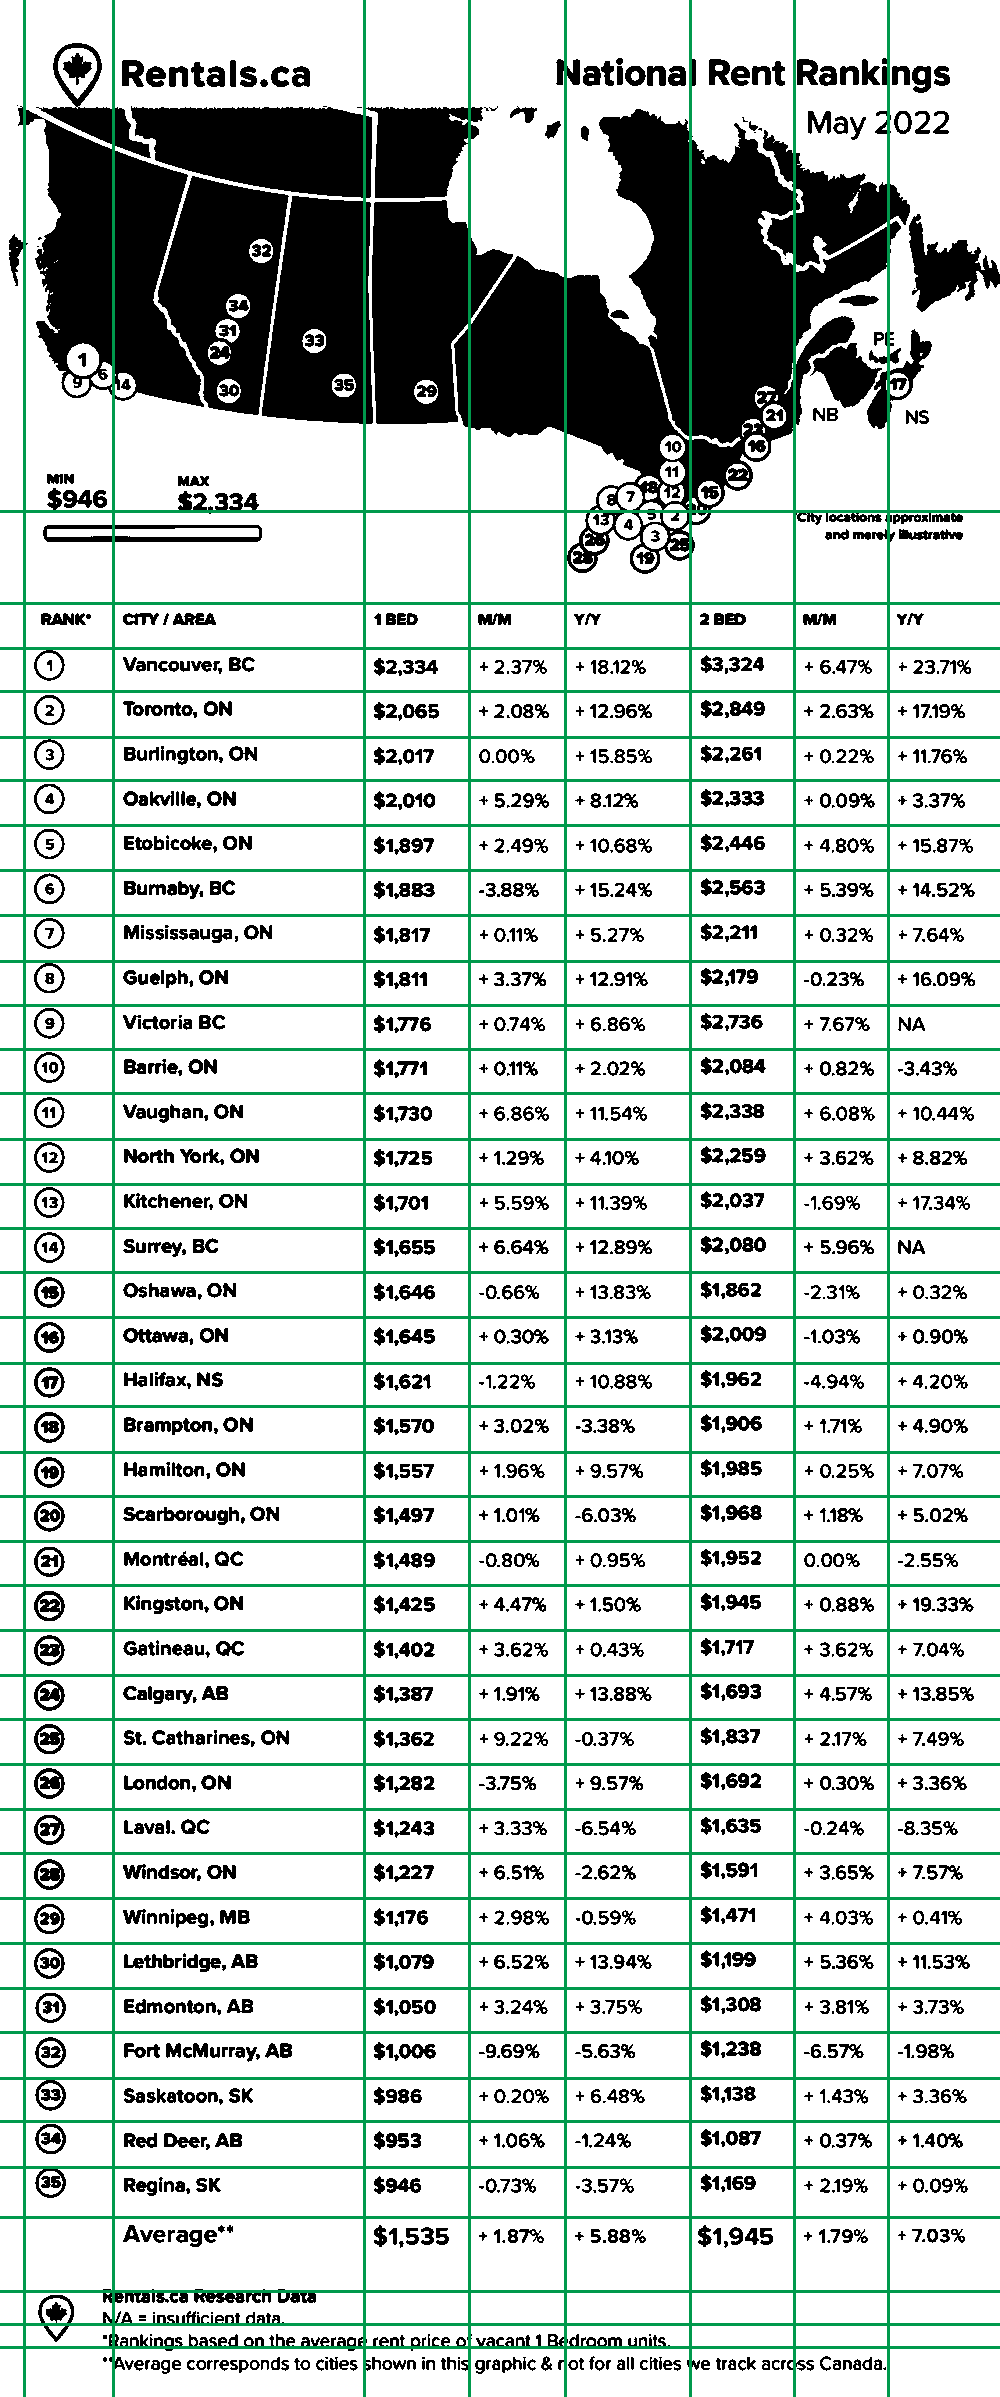

In [ ]:
# Redefining preprocessed sample as a BGR OpenCV image
color_preprocessed = cv2.cvtColor(preprocessed_image, cv2.COLOR_GRAY2BGR)

# Table lines color
lines_color = [76, 153, 0] # mild pale green

# Plotting resulting vertical lines
for v_line in v_lines:
  cv2.line(color_preprocessed,
           (v_line, 0),
           (v_line, color_preprocessed.shape[0]),
           color = lines_color,
           thickness = 2)

# Plotting resulting horizontal lines
for h_line in h_lines:
  cv2.line(color_preprocessed,
           (0, h_line),
           (color_preprocessed.shape[1], h_line),
           color = lines_color,
           thickness = 2)

cv2_imshow(color_preprocessed)

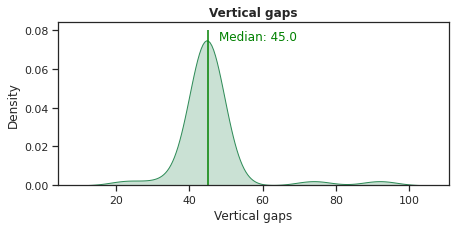

In [ ]:
# Vertical line gaps distribution
v_gaps = [h_lines[i+1] - h_lines[i] for i in range(len(h_lines) - 1)]

plt.figure(figsize = (7, 3))
hist = sns.kdeplot(x = v_gaps, shade = True)
hist.vlines(median(v_gaps), 0, 0.08, color = "green")
hist.text(median(v_gaps) + 3, 0.075,
          f"Median: {median(v_gaps)}",
          color = "green")
hist.set_title("Vertical gaps", size = 12, weight = "bold")
hist.set(xlabel = "Vertical gaps")
plt.show()

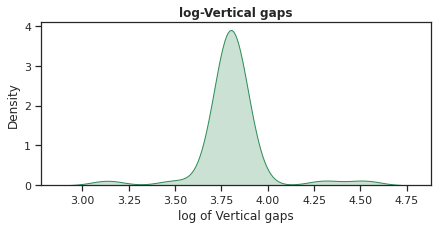

In [ ]:
# Log of vertical gaps to approximate to a normal distribution
log_v_gaps = np.log(v_gaps)

plt.figure(figsize = (7, 3))
hist = sns.kdeplot(x = log_v_gaps, shade = True)
hist.set_title("log-Vertical gaps", size = 12, weight = "bold")
hist.set(xlabel = "log of Vertical gaps")
plt.show()

In [ ]:
# Vertical gaps smoothening factor
smooth_v_factor = 3

stdev_v_gaps = stdev(log_v_gaps)
mean_v_gaps = mean(log_v_gaps)
smooth_v_increment = smooth_v_factor * (stdev_v_gaps / np.sqrt(len(v_gaps)))
smooth_v_interval = (mean_v_gaps - smooth_v_increment, mean_v_gaps + smooth_v_increment)

# Converting back to original scale
smooth_v_interval = np.exp(smooth_v_interval).astype("int8")

# Converting to a range interval
smooth_v_interval = range(smooth_v_interval[0], smooth_v_interval[1])
smooth_v_interval

range(41, 49)

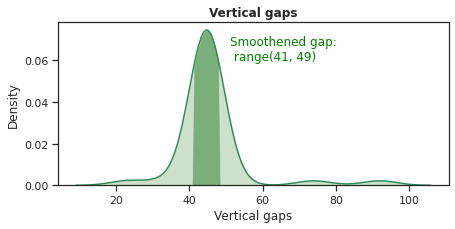

In [ ]:
# Vertical line gaps distribution with smoothened interval
v_gaps = [h_lines[i+1] - h_lines[i] for i in range(len(h_lines) - 1)]

plt.figure(figsize = (7, 3))
hist = sns.kdeplot(x = v_gaps, shade = False)
hist.text(median(v_gaps) + 6, 0.06,
          f"Smoothened gap:\n {smooth_v_interval}",
          color = "green")
kdeline = hist.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
left = smooth_v_interval[0]
right = smooth_v_interval[-1]
hist.fill_between(xs, 0, ys,
                  facecolor = 'darkgreen',
                  alpha = 0.2)
hist.fill_between(xs, 0, ys,
                  where = (left <= xs) & (xs <= right),
                  interpolate = True,
                  facecolor = 'darkgreen',
                  alpha = 0.4)
hist.set_title("Vertical gaps", size = 12, weight = "bold")
hist.set(xlabel = "Vertical gaps")
plt.show()

In [ ]:
# Updating horizontal lines based on smoothened vertical interval
smooth_h_lines = []

for i, line in enumerate(h_lines):
  try:
    # Look forward for at least 2 gaps in a row within smoothened interval
    if h_lines[i+2] - h_lines[i+1] in smooth_v_interval:
      if h_lines[i+1] - h_lines[i] in smooth_v_interval:
        smooth_h_lines.append(line)
    # Look backward for at least 2 gaps in a row within smoothened interval
    elif h_lines[i-1] - h_lines[i-2] in smooth_v_interval:
      if h_lines[i] - h_lines[i-1] in smooth_v_interval:
        smooth_h_lines.append(line)
  except:
    pass

In [ ]:
# Defining external borders
# Calculating mean vertical spacing within table
v_spacings = []

for i in range(0, len(smooth_h_lines) - 1):
  v_spacings.append(smooth_h_lines[i+1] - smooth_h_lines[i])

# Subtracting mean 
v_spacing = int(mean(v_spacings) - mean([h[3] for h in extracted_table['coords']]))

# Coordinates on last column
last_column_widths = []
for id in np.where([x[0] for x in extracted_table['coords']] > np.max(v_lines))[0]:
  last_column_widths.append(extracted_table['coords'][id][2])

last_column_width = np.max(last_column_widths) + 2*h_padding

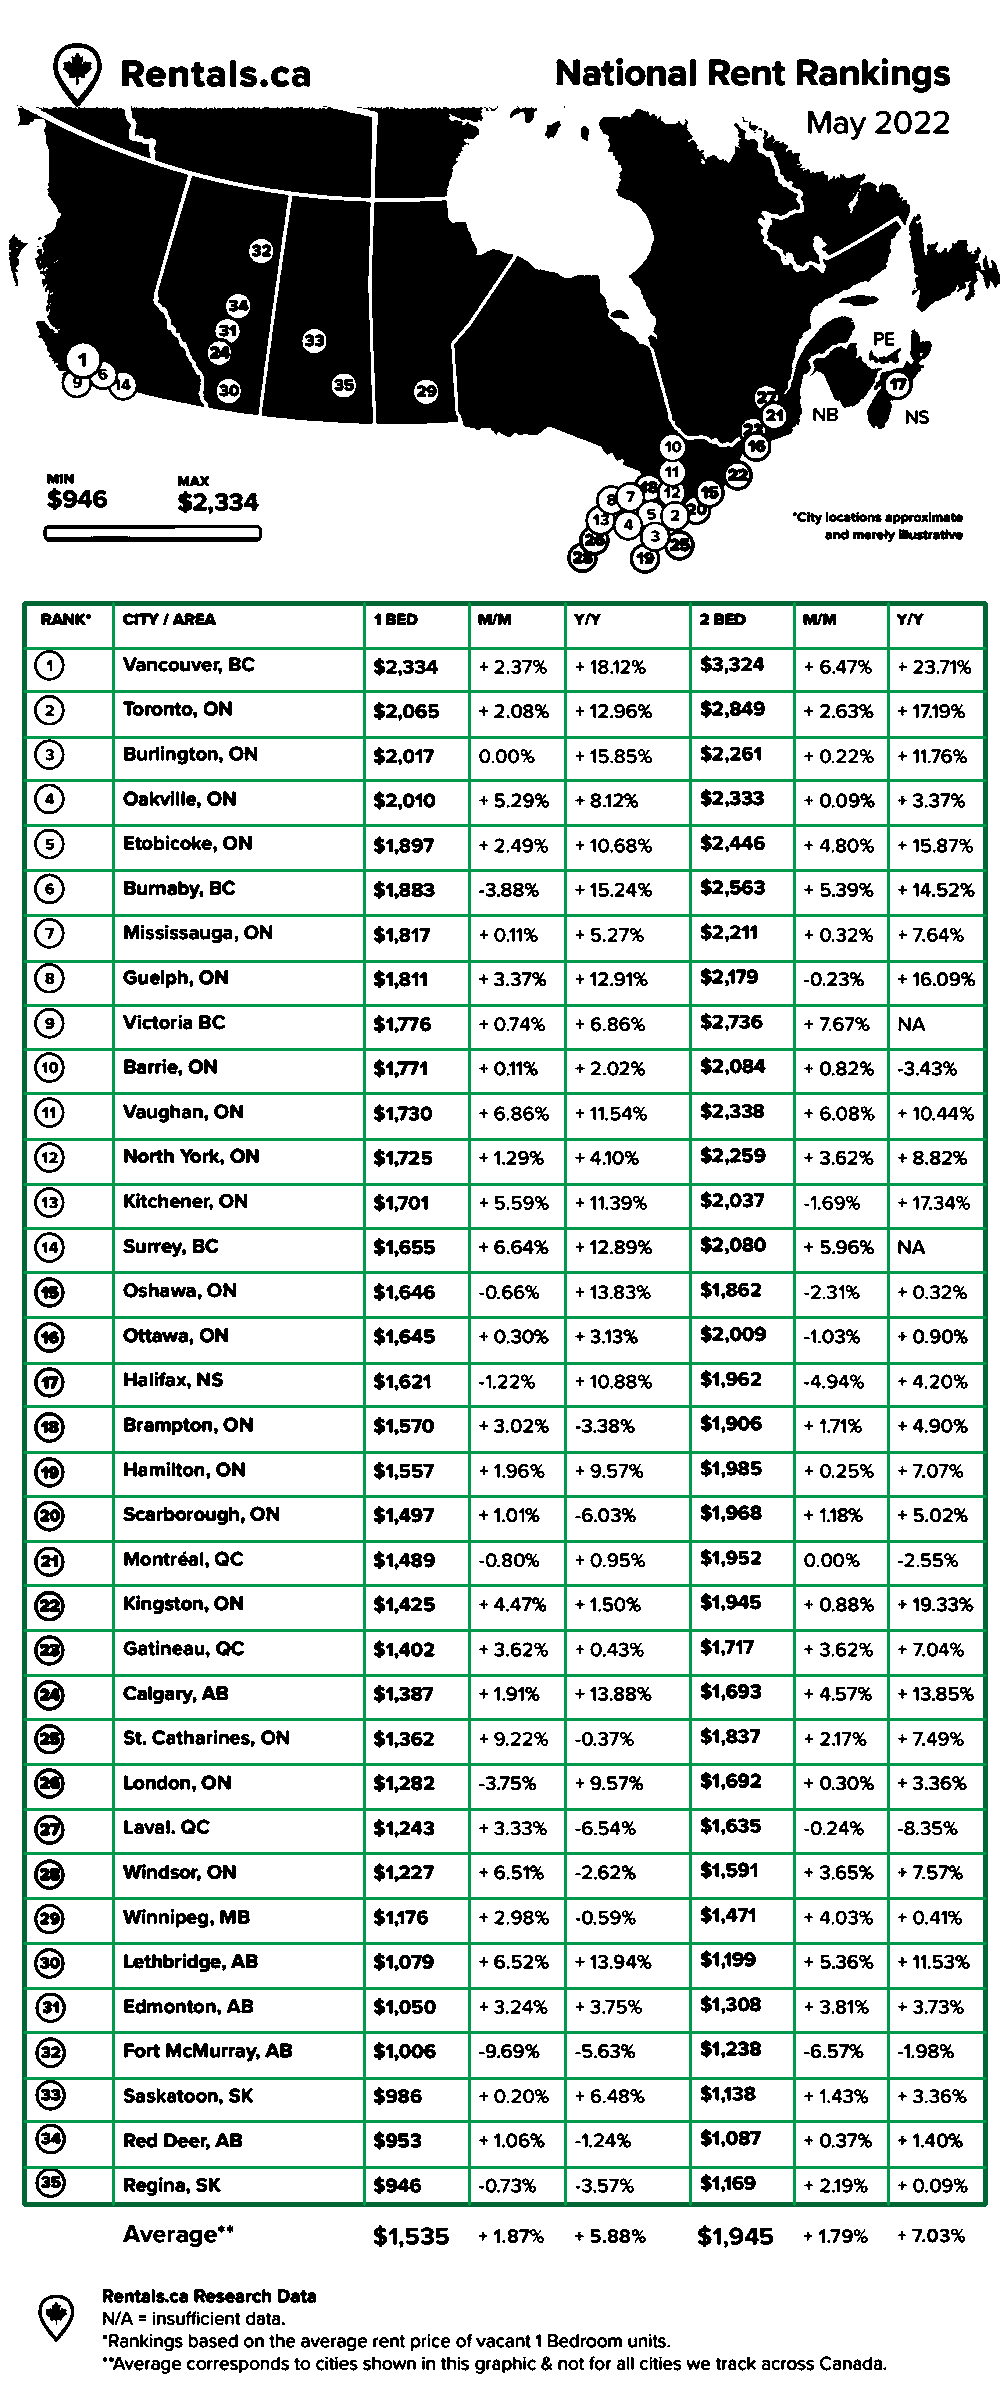

In [ ]:
# Drawing final table layout
color_preprocessed = cv2.cvtColor(preprocessed_image, cv2.COLOR_GRAY2BGR)

border_color = [51, 102, 0] # dark green
lines_color = [76, 153, 0] # mild pale green

# Table corners
x_min = np.min(v_lines)
y_min = np.min(smooth_h_lines)
x_max = np.max(v_lines) + last_column_width
y_max = np.max(smooth_h_lines) + v_spacing + v_padding

# Drawing external borders
cv2.rectangle(color_preprocessed,
              (x_min, y_min),
              (x_max, y_max),
              color = border_color,
              thickness = 3)

for v_line in v_lines:
  if v_line != x_min:
    cv2.line(color_preprocessed,
            (v_line, y_min),
            (v_line, y_max),
             color = lines_color,
             thickness = 2)
    
for h_line in smooth_h_lines:
  if h_line != y_min:
    cv2.line(color_preprocessed,
             (x_min, h_line),
             (x_max, h_line),
             color = lines_color,
             thickness = 2)

cv2_imshow(color_preprocessed)

In [ ]:
# Columns ranges
columns = []
for i in range(0, len(v_lines) -1):
  columns.append(range(v_lines[i], v_lines[i+1]))

# Appending last column
columns.append(range(v_lines[-1], x_max))

# Rows ranges
rows = []
for i in range(0, len(smooth_h_lines) -1):
  rows.append(range(smooth_h_lines[i], smooth_h_lines[i+1]))

# Appending last row
rows.append(range(smooth_h_lines[-1], y_max))

In [ ]:
# Final table dimensions
n_rows = len(smooth_h_lines)
table_dim = (n_rows, n_columns)

# Initializing an empy NumPy array to store table data
table = np.empty(table_dim, dtype = 'object')

for coord, text in zip(extracted_table['coords'], extracted_table['OCRtext']):
  for j in range(0, len(columns)):
    for i in range(0, len(rows)):
      if (int(coord[0] + coord[2]/2) in columns[j]) and (int(coord[1] + coord[3]/2) in rows[i]):
        # Check for cells with existing text element and concatenate
        if table[i, j] is not None:
          table[i, j] += f" {text}"
        # Or populate it with a new element
        else:
          table[i, j] = text

pd.DataFrame(table[1:], columns = table[0])

,RANK,CITY / AREA,4BED,mM,YY,2BED,mM,vie
0,None,"Vancouver, BC","$2,334",+2.37%,+1812%,"$3,324",+647%,+23.71%
1,@,"Toronto, ON","$2,065",+2.08%,+12.96%,"$2,849",+263%,+1719%
2,®,"Burlington, ON","$2,017",0.00%,+ 15.85%,"$2,261",+ 0.22%,+ 11.76%
3,@,"Oakville, ON","$2,010","+5,29%",None,"$2,333",+0.09%,+3.37%
4,®,"Etobicoke, ON",$1897,+249%,+1068%,"$2,446",+480%,+15.87%
5,©,"Bumaby, BC",$1883,-388%,None,"$2,563",+539%,+14.52%
6,@,"Mississauga, ON","$1,817",401%,+5.27%,"$2,211",+0.32%,+7.64%
7,None,"Guelph, ON",$ian,+3.37%,+12.91%,$2179,-0.23%,+ 16.09%
8,®,Victoria BC,None,None,+ 6.86%,"$2,736",+767%,NA
9,None,"Barrie, ON",$1771,None,+2.02%,"$2,084",+0.82%,-3.43%
